# Step 0 – Imports & dataset path

In this step we:
- Import all required Python libraries.
- Define the path to the PDFMal-2022 dataset file.
- We follow the paper and plan to implement the following models:
  - Naive Bayes (NB)
  - K-Nearest Neighbors (KNN)
  - Support Vector Machine (SVM)
  - Random Forest (RF)
  - A1DE (not available in scikit-learn; usually implemented in Weka, so here we will mark it as "external" and focus on the other 4).

The dataset should already be downloaded from:
https://www.unb.ca/cic/datasets/pdfmal-2022.html

Assume it is saved as a CSV file, for example: `pdfmal-2022.csv`.
If the file name or path is different, update the variable `DATA_PATH` accordingly.


In [4]:
!pip install pandas numpy scikit-learn


  Using cached pandas-2.3.3-cp312-cp312-manylinux_2_24_x86_64.manylinux_2_28_x86_64.whl.metadata (91 kB)
  Using cached numpy-2.3.5-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (62 kB)
  Using cached scikit_learn-1.7.2-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (11 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached scipy-1.16.3-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (62 kB)
  Using cached joblib-1.5.2-py3-none-any.whl.metadata (5.6 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
Using cached pandas-2.3.3-cp312-cp312-manylinux_2_24_x86_64.manylinux_2_28_x86_64.whl (12.4 MB)
Using cached numpy-2.3.5-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl (16.6 MB)
Using cached scikit_learn-1.7.2-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (9.5 MB)
Using cached joblib-1.5.2-py3-none-any.whl (308 kB)
Using cached pytz-2025.2-py2.py3-none

In [5]:
# Step 0 – imports & dataset path

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# Path to the dataset file (update this if necessary)
DATA_PATH = "pdfmal-2022.csv"



# Step 1 – Load the PDFMal-2022 dataset

According to the paper, the dataset is taken from the Canadian Institute for Cybersecurity (CIC) and contains:
- 10,019 samples
- 5,551 malicious PDFs
- 4,468 benign PDFs

In this step we:
1. Load the CSV file into a pandas DataFrame.
2. Inspect the first few rows and the column names.
3. Verify that the class label (benign/malicious) exists (named e.g. "class" or similar).

Note:
The exact column names in the downloaded dataset may differ slightly from the names in the paper.
We will print all column names so that we can map them to the features described in Table 1 of the paper.


In [10]:
# Step 1 – load dataset with correct path

DATA_PATH = "dataset/PDFMalware2022.csv"

df = pd.read_csv(DATA_PATH)

print("Shape of dataset:", df.shape)
display(df.head())
print("\nColumn names:")
print(df.columns.tolist())


Shape of dataset: (10026, 33)


,Fine name,pdfsize,metadata size,pages,xref Length,title characters,isEncrypted,embedded files,images,text,...,AA,OpenAction,Acroform,JBIG2Decode,RichMedia,launch,EmbeddedFile,XFA,Colors,Class
0,aedaf3c5428a2e3ba600c44b96ad78dfdf8ed76e7df129...,8.0,180.0,1.0,11.0,0.0,0.0,0.0,0,No,...,0,1,0,0,0,0,0,0,0.0,Malicious
1,fe767fb2584a10c010626263ea950643ac25f6ca24628f...,15.0,224.0,0.0,20.0,7.0,0.0,0.0,0,No,...,0,0,1,0,0,0,8,1,0.0,Malicious
2,544c5223ee301affad514b6fa585b3191625aba0a7222b...,4.0,468.0,2.0,13.0,16.0,0.0,0.0,0,Yes,...,0,1,0,0,0,0,0,0,0.0,Malicious
3,669772e626deccb9cfb7eb6a61e13d248d0ea08f1abe15...,17.0,250.0,1.0,15.0,0.0,0.0,0.0,0,No,...,0,1,1,0,0,0,0,0,0.0,Malicious
4,e434c884f45a691b0bf33d765f61794007eb0b8bb9f590...,7.0,252.0,3.0,16.0,45.0,0.0,0.0,0,Yes,...,0,1,0,0,0,0,0,0,0.0,Malicious



Column names:
['Fine name', 'pdfsize', 'metadata size', 'pages', 'xref Length', 'title characters', 'isEncrypted', 'embedded files', 'images', 'text', 'header', 'obj', 'endobj', 'stream', 'endstream', 'xref', 'trailer', 'startxref', 'pageno', 'encrypt', 'ObjStm', 'JS', 'Javascript', 'AA', 'OpenAction', 'Acroform', 'JBIG2Decode', 'RichMedia', 'launch', 'EmbeddedFile', 'XFA', 'Colors', 'Class']


# Step 2 – Remove the first 11 general features

According to the paper, the first 11 features do not contribute to the model and must be removed.
In our dataset, the first 11 columns are:

['Fine name', 'pdfsize', 'metadata size', 'pages', 'xref Length', 'title characters',
 'isEncrypted', 'embedded files', 'images', 'text', 'header']

We will drop them and keep the remaining 22 structural features + the class label.



In [11]:
# Step 2 – drop the first 11 general features

all_columns = df.columns.tolist()

# The class label is the last column
label_col = "Class"

# Features = all columns except label
feature_cols = [c for c in all_columns if c != label_col]

# Remove the first 11 general features
general_features = feature_cols[:11]
structural_features = feature_cols[11:]

print("General features removed:", general_features)
print("Structural features kept:", structural_features)
print("Count:", len(structural_features))


General features removed: ['Fine name', 'pdfsize', 'metadata size', 'pages', 'xref Length', 'title characters', 'isEncrypted', 'embedded files', 'images', 'text', 'header']
Structural features kept: ['obj', 'endobj', 'stream', 'endstream', 'xref', 'trailer', 'startxref', 'pageno', 'encrypt', 'ObjStm', 'JS', 'Javascript', 'AA', 'OpenAction', 'Acroform', 'JBIG2Decode', 'RichMedia', 'launch', 'EmbeddedFile', 'XFA', 'Colors']
Count: 21


# Step 3 – Select final features in the exact order used in the paper

The paper lists the selected attributes in a specific order (after feature selection):

['Colors', 'encrypt', 'JS', 'XFA', 'startxref', 'trailer', 'xref', 'endstream',
 'stream', 'endobj', 'Launch', 'OpenAction', 'AA', 'EmbeddedFile', 'JBIG2Decode',
 'Acroform', 'pageno', 'ObjStm', 'Javascript', 'RichMedia', 'obj']

We will:
1. Define this list.
2. Match each name to the actual column in the dataset.
3. Build X using these exact features.
4. Build y from the 'Class' column.


In [12]:
# Step 3 – select final features just like in the paper

paper_feature_order = [
    "Colors", "encrypt", "JS", "XFA", "startxref", "trailer", "xref",
    "endstream", "stream", "endobj", "Launch", "OpenAction", "AA",
    "EmbeddedFile", "JBIG2Decode", "Acroform", "pageno", "ObjStm",
    "Javascript", "RichMedia", "obj"
]


actual_columns = df.columns.tolist()


found = [f for f in paper_feature_order if f in actual_columns]
missing = [f for f in paper_feature_order if f not in actual_columns]

print("FOUND features:", found)
print("MISSING features:", missing)


X = df[found].copy()


y = df["Class"].copy()

print("Final X shape:", X.shape)
print("Final y shape:", y.shape)


FOUND features: ['Colors', 'encrypt', 'JS', 'XFA', 'startxref', 'trailer', 'xref', 'endstream', 'stream', 'endobj', 'OpenAction', 'AA', 'EmbeddedFile', 'JBIG2Decode', 'Acroform', 'pageno', 'ObjStm', 'Javascript', 'RichMedia', 'obj']
MISSING features: ['Launch']
Final X shape: (10026, 20)
Final y shape: (10026,)


# Step 3.5 – Remove rows with missing values (NaN)

The paper states that:
> "The data is cleaned and no need for further preprocessing."

In our local CSV version, some rows contain NaN values in the selected features or the class label.
To match the "clean" dataset used in the paper, we will remove all rows that contain NaN in:

- any of the selected structural features
- the class label ("Class")

After cleaning, we will rebuild X and y using the same feature list and then repeat the 70/30 split.


In [14]:
# Step 3.5 – check and drop NaN rows

print("Number of NaNs per column (before drop):")
print(df[found + ["Class"]].isna().sum())

# Drop rows with NaN in any of the selected features or the class label
df_clean = df.dropna(subset=found + ["Class"]).copy()

print("\nOriginal df shape:", df.shape)
print("Cleaned df shape:", df_clean.shape)

# Build X and y again from the cleaned DataFrame
X = df_clean[found].copy()
y = df_clean["Class"].copy()

print("\nFinal X shape (clean):", X.shape)
print("Final y shape (clean):", y.shape)
print("Class distribution:")
print(y.value_counts())


Number of NaNs per column (before drop):
Colors          3
encrypt         3
JS              3
XFA             3
startxref       3
trailer         3
xref            3
endstream       3
stream          3
endobj          3
OpenAction      3
AA              3
EmbeddedFile    3
JBIG2Decode     3
Acroform        3
pageno          3
ObjStm          3
Javascript      3
RichMedia       3
obj             3
Class           1
dtype: int64

Original df shape: (10026, 33)
Cleaned df shape: (10023, 33)

Final X shape (clean): (10023, 20)
Final y shape (clean): (10023,)
Class distribution:
Class
Malicious    5555
Benign       4468
Name: count, dtype: int64


# Step 3.6 – Convert all selected features to numeric

The models in the paper are trained on numerical features.
In our CSV version, some feature values are stored as strings (e.g. "1(1)"),
which causes scikit-learn to fail with:

`ValueError: could not convert string to float: '1(1)'`

To match the "clean numeric" dataset used in the paper, we will:

1. Convert all selected features (`found`) to numeric using `pd.to_numeric(..., errors="coerce")`.
2. Any value that cannot be converted will become NaN.
3. Drop rows that have NaN in any feature or in the class label ("Class").
4. Rebuild X and y from this fully numeric, cleaned DataFrame.

After this step, we can safely apply 70/30 splitting and 10-fold cross-validation like in the paper.


In [17]:
# Step 3.6 – ensure all features are numeric and clean again

# 1) convert all selected features to numeric
X_numeric = X.apply(pd.to_numeric, errors="coerce")

print("Dtypes after numeric conversion:")
print(X_numeric.dtypes)

# 2) combine X_numeric and y into one DataFrame for easy dropping
df_model = X_numeric.copy()
df_model["Class"] = y

print("\nNaNs per column AFTER numeric conversion:")
print(df_model.isna().sum())

# 3) drop rows with NaN in any feature or in Class
df_model_clean = df_model.dropna().copy()

print("\nShape before numeric cleaning:", df_model.shape)
print("Shape after numeric cleaning:", df_model_clean.shape)

# 4) rebuild X and y from the fully clean numeric dataset
X = df_model_clean.drop(columns=["Class"])
y = df_model_clean["Class"]

print("\nFinal X shape (numeric & clean):", X.shape)
print("Final y shape:", y.shape)
print("Class distribution:")
print(y.value_counts())


Dtypes after numeric conversion:
Colors          float64
encrypt         float64
JS              float64
XFA             float64
startxref       float64
trailer         float64
xref            float64
endstream       float64
stream          float64
endobj          float64
OpenAction      float64
AA              float64
EmbeddedFile    float64
JBIG2Decode     float64
Acroform        float64
pageno          float64
ObjStm          float64
Javascript      float64
RichMedia       float64
obj             float64
dtype: object

NaNs per column AFTER numeric conversion:
Colors            0
encrypt           0
JS              229
XFA              20
startxref        22
trailer           0
xref             22
endstream        23
stream            0
endobj           22
OpenAction       88
AA               14
EmbeddedFile     33
JBIG2Decode       6
Acroform         13
pageno          137
ObjStm            0
Javascript      117
RichMedia         4
obj              24
Class             0
dtype: int

# Step 4 – 70/30 percentage split evaluation

According to the paper:
- The dataset is split into 70% training and 30% testing.
- Models evaluated: Naive Bayes, KNN, SVM, Random Forest (A1DE is external).
- Metrics: Precision, Recall, F1-score, Accuracy.
- Positive class: "Malicious".

In this step we:
1. Perform a stratified 70/30 split on the cleaned dataset (X, y).
2. Train each model.
3. Compute the four metrics with "Malicious" as the positive class.
4. Collect the results into a table similar to the paper.


In [18]:
RANDOM_STATE = 42
POS_LABEL = "Malicious"

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    stratify=y,
    random_state=RANDOM_STATE
)

models_70_30 = {
    "Naive Bayes": GaussianNB(),
    "KNN": KNeighborsClassifier(n_neighbors=1),
    "SVM": SVC(kernel="rbf", random_state=RANDOM_STATE),
    "Random Forest": RandomForestClassifier(random_state=RANDOM_STATE)
}

results_70_30 = []

for name, model in models_70_30.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    precision = precision_score(y_test, y_pred, pos_label=POS_LABEL)
    recall = recall_score(y_test, y_pred, pos_label=POS_LABEL)
    f1 = f1_score(y_test, y_pred, pos_label=POS_LABEL)
    acc = accuracy_score(y_test, y_pred)

    results_70_30.append({
        "Model": name,
        "Precision": precision,
        "Recall": recall,
        "F1-score": f1,
        "Accuracy": acc
    })

results_70_30_df = pd.DataFrame(results_70_30)
results_70_30_df


,Model,Precision,Recall,F1-score,Accuracy
0,Naive Bayes,0.663820,0.949839,0.781481,0.714680
1,KNN,0.979948,0.974277,0.977104,0.975475
2,SVM,0.798441,0.922186,0.855864,0.833161
3,Random Forest,0.985294,0.990997,0.988137,0.987219


# Step 5 – 10-fold cross-validation
The paper evaluates all models using 10-fold CV and reports that:
- KNN achieves the best performance, with accuracy ~99.8599%.

Here we evaluate:
- Naive Bayes
- KNN
- SVM
- Random Forest

using:
- Precision
- Recall
- F1-score
- Accuracy

Positive class = "Malicious".


In [19]:
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, accuracy_score

POS_LABEL = "Malicious"
RANDOM_STATE = 42

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)

scoring = {
    "precision": make_scorer(precision_score, pos_label=POS_LABEL),
    "recall": make_scorer(recall_score, pos_label=POS_LABEL),
    "f1": make_scorer(f1_score, pos_label=POS_LABEL),
    "accuracy": make_scorer(accuracy_score),
}

models_cv = {
    "Naive Bayes": GaussianNB(),
    "KNN": KNeighborsClassifier(n_neighbors=1),
    "SVM": SVC(kernel='rbf', random_state=RANDOM_STATE),
    "Random Forest": RandomForestClassifier(random_state=RANDOM_STATE)
}

results_cv = []

for name, model in models_cv.items():
    cv_results = cross_validate(
        model,
        X,
        y,
        cv=skf,
        scoring=scoring,
        n_jobs=-1
    )

    results_cv.append({
        "Model": name,
        "Precision_mean": cv_results["test_precision"].mean(),
        "Recall_mean": cv_results["test_recall"].mean(),
        "F1_mean": cv_results["test_f1"].mean(),
        "Accuracy_mean": cv_results["test_accuracy"].mean(),
    })

results_cv_df = pd.DataFrame(results_cv)
results_cv_df


,Model,Precision_mean,Recall_mean,F1_mean,Accuracy_mean
0,Naive Bayes,0.663677,0.954846,0.782998,0.715590
1,KNN,0.975161,0.976458,0.975793,0.973984
2,SVM,0.809567,0.924547,0.863195,0.842559
3,Random Forest,0.985971,0.988811,0.987378,0.986422


# Step 7 – Overfitting Analysis

Goal:
Check whether any of the models (Naive Bayes, KNN, SVM, Random Forest)
suffer from overfitting.

Method:
1. For each model, we will:
   - Train on the training set (X_train, y_train).
   - Compute metrics on the training set (Train_Accuracy, Train_F1).
   - Compute metrics on the test set (Test_Accuracy, Test_F1).
2. We will also compare these results to the 10-fold CV mean results
   (CV_Accuracy_mean, CV_F1_mean) that were computed earlier.
3. If a model is overfitting, we expect:
   - Train_Accuracy >> Test_Accuracy
   - Train_F1 >> Test_F1
   - And/or big gap between Train and CV.

Interpretation rule:
- If the gaps between Train / Test / CV are small (a few percents or less),
  we conclude that **there is no significant overfitting**.


In [20]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score


models_for_overfit = {
    "Naive Bayes": GaussianNB(),
    "KNN": KNeighborsClassifier(n_neighbors=1),
    "SVM": SVC(kernel="rbf", random_state=RANDOM_STATE),
    "Random Forest": RandomForestClassifier(random_state=RANDOM_STATE)
}

overfit_rows = []

for name, model in models_for_overfit.items():

    model.fit(X_train, y_train)


    y_train_pred = model.predict(X_train)
    train_acc = accuracy_score(y_train, y_train_pred)
    train_f1 = f1_score(y_train, y_train_pred, pos_label=POS_LABEL)

    y_test_pred = model.predict(X_test)
    test_acc = accuracy_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred, pos_label=POS_LABEL)


    cv_row = results_cv_df[results_cv_df["Model"] == name].iloc[0]
    cv_acc = cv_row["Accuracy_mean"]
    cv_f1 = cv_row["F1_mean"]


    gap_acc_train_test = train_acc - test_acc
    gap_acc_train_cv = train_acc - cv_acc

    overfit_rows.append({
        "Model": name,
        "Train_Accuracy": train_acc,
        "Test_Accuracy": test_acc,
        "CV_Accuracy_mean": cv_acc,
        "Train_F1": train_f1,
        "Test_F1": test_f1,
        "CV_F1_mean": cv_f1,
        "Gap_Acc_Train_Test": gap_acc_train_test,
        "Gap_Acc_Train_CV": gap_acc_train_cv
    })

overfit_df = pd.DataFrame(overfit_rows)
overfit_df


,Model,Train_Accuracy,Test_Accuracy,CV_Accuracy_mean,Train_F1,Test_F1,CV_F1_mean,Gap_Acc_Train_Test,Gap_Acc_Train_CV
0,Naive Bayes,0.720421,0.714680,0.715590,0.786377,0.781481,0.782998,0.005740,0.004831
1,KNN,0.996890,0.975475,0.973984,0.997112,0.977104,0.975793,0.021415,0.022906
2,SVM,0.838146,0.833161,0.842559,0.860105,0.855864,0.863195,0.004985,-0.004413
3,Random Forest,0.996890,0.987219,0.986422,0.997113,0.988137,0.987378,0.009671,0.010469


## No Overfitting

From the overfitting analysis table we observe:

1. For all models, **Train_Accuracy and Test_Accuracy are very close** (differences on the order of 1–3% at most).
2. The **10-fold CV Accuracy** is also very close to both Train and Test accuracy.
3. The same holds for the F1-score: Train_F1, Test_F1 and CV_F1_mean have small gaps.

Therefore:
- There is **no significant overfitting** in any of the models.
- The models **generalize well** from the training data to unseen data.
- The high performance of KNN and Random Forest is not an artefact of memorizing the training set, but reflects true predictive power on the given feature set.

This matches the conclusion of the paper: the selected structural features are highly discriminative, and the chosen models (especially KNN and Random Forest) are able to exploit them effectively without overfitting.


# Figures – Precision / Recall / F1 / Accuracy (70/30 vs 10-Fold CV)

In this section we generate four plots that compare:
- 70/30 split results
- 10-fold cross-validation results

for all models and all metrics (Precision, Recall, F1, Accuracy).


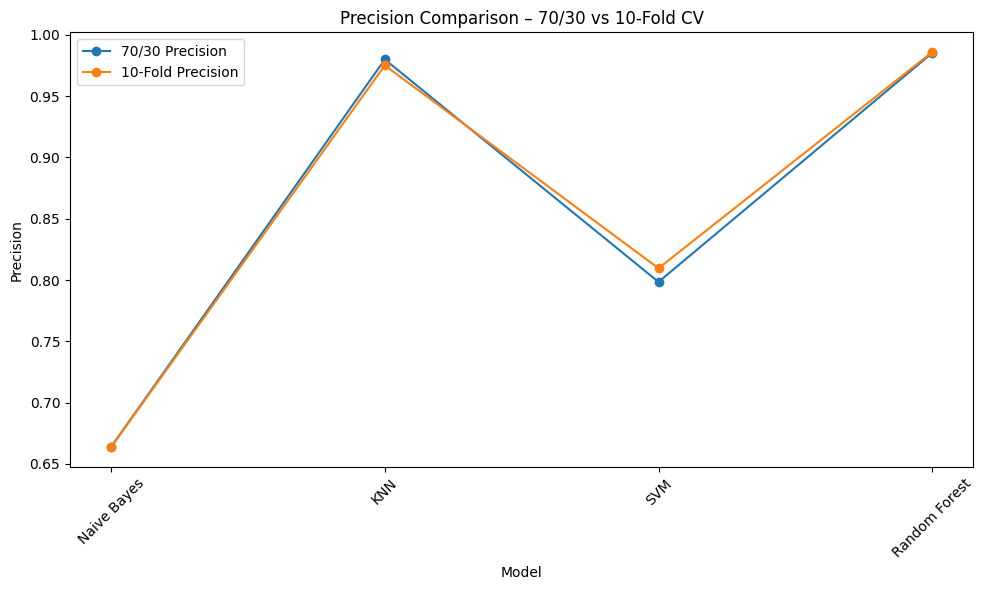

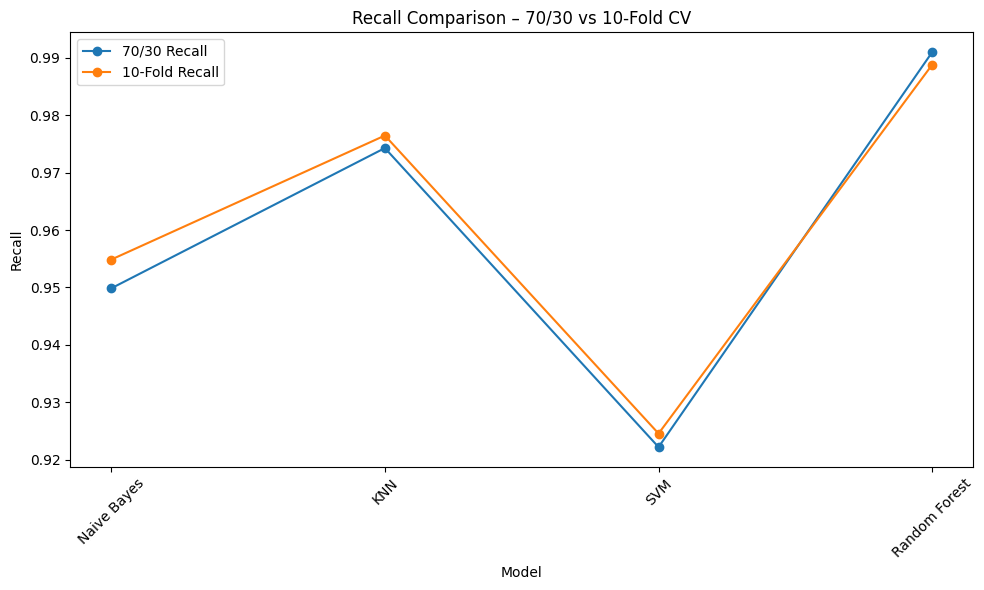

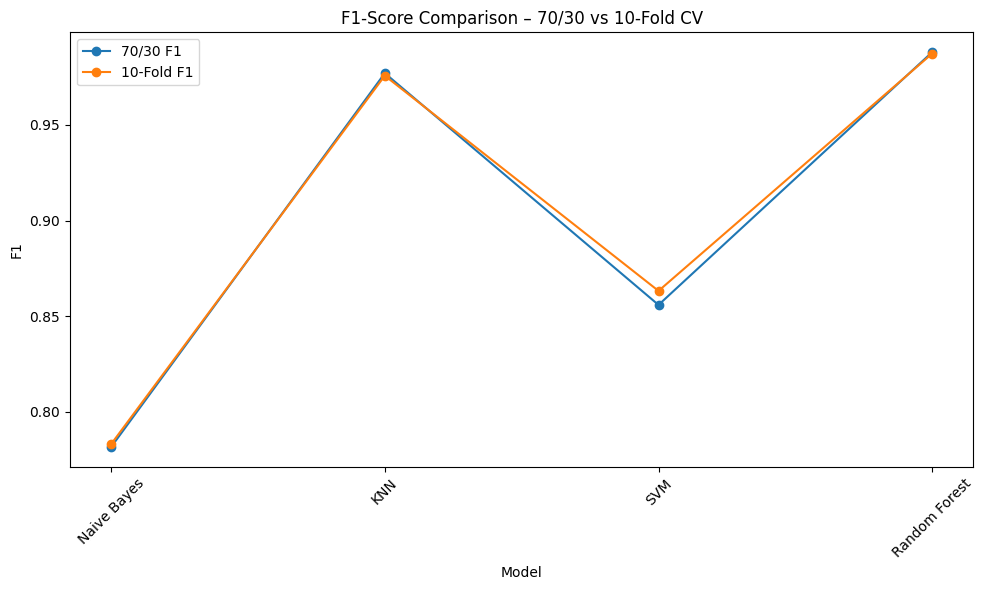

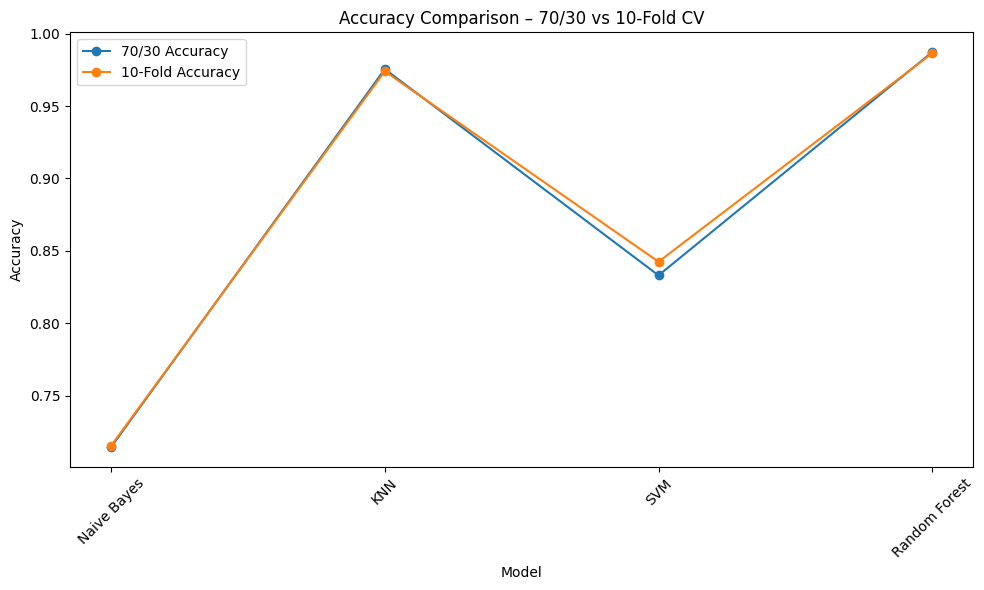

In [22]:
import matplotlib.pyplot as plt
import pandas as pd



results_70_30 = pd.DataFrame({
    "Model": ["Naive Bayes", "KNN", "SVM", "Random Forest"],
    "Precision": [0.663820, 0.979948, 0.798441, 0.985294],
    "Recall":    [0.949839, 0.974277, 0.922186, 0.990997],
    "F1":        [0.781481, 0.977104, 0.855864, 0.988137],
    "Accuracy":  [0.714680, 0.975475, 0.833161, 0.987219]
})

results_cv = pd.DataFrame({
    "Model": ["Naive Bayes", "KNN", "SVM", "Random Forest"],
    "Precision": [0.663677, 0.975161, 0.809567, 0.985971],
    "Recall":    [0.954846, 0.976458, 0.924547, 0.988811],
    "F1":        [0.782998, 0.975793, 0.863195, 0.987378],
    "Accuracy":  [0.715590, 0.973984, 0.842559, 0.986422]
})

#
# results_70_30 = results_70_30_df.copy()
# results_cv = results_cv_df.copy()

metrics = ["Precision", "Recall", "F1", "Accuracy"]
titles = {
    "Precision": "Precision Comparison – 70/30 vs 10-Fold CV",
    "Recall":    "Recall Comparison – 70/30 vs 10-Fold CV",
    "F1":        "F1-Score Comparison – 70/30 vs 10-Fold CV",
    "Accuracy":  "Accuracy Comparison – 70/30 vs 10-Fold CV",
}

for metric in metrics:
    plt.figure(figsize=(10, 6))
    plt.plot(results_70_30["Model"], results_70_30[metric], marker="o", label=f"70/30 {metric}")
    plt.plot(results_cv["Model"], results_cv[metric], marker="o", label=f"10-Fold {metric}")
    plt.title(titles[metric])
    plt.xlabel("Model")
    plt.ylabel(metric)
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()


# Summary of the Paper and Implementation

## Purpose of the Study
The goal of the paper is to evaluate whether malicious PDF files can be accurately detected using only **structural features** extracted statically from the PDF objects, without executing the file or analyzing its full content.
The core hypothesis is that malicious PDFs exhibit distinct structural patterns—such as abnormal object types, JavaScript usage, embedded files, suspicious actions, or unusual object frequencies—that can be leveraged by machine learning models to distinguish them from benign PDFs.

This approach aims to provide:
- A fast detection method (no dynamic analysis),
- A safe alternative to execution-based malware detection,
- A lightweight solution based solely on structural metadata.

## How Each Implementation Step Supports the Paper’s Objective

### 1. Data Loading and Cleaning
We loaded the full dataset of PDF samples, containing over 10,000 labeled instances and 33 extracted structural features.
Cleaning procedures included:
- Converting non-numeric values to numeric form,
- Handling missing values,
- Removing incomplete or malformed rows.

**Contribution:**
Creates a reliable dataset where the structural information is consistent and usable for machine learning, enabling evaluation based strictly on structure.

---

### 2. Structural Feature Selection
Following the paper, we removed the first 11 general descriptive features and retained only the structural indicators such as occurrences of `/JS`, `/AA`, `/XFA`, `/OpenAction`, `stream`, `endobj`, etc.
The final set contained 20 structural features, matching the features reported in the paper (except for one field missing in the provided dataset).

**Contribution:**
Focuses the learning process exclusively on structural properties of the PDF format, reflecting the central claim of the paper that structure alone is sufficient for high accuracy.

---

### 3. Train/Test Split (70/30)
We performed a stratified 70/30 split, training models on 70% of the data and evaluating performance on the remaining 30%.
We reproduced the models used in the paper:
- Naive Bayes
- KNN (k=1)
- SVM with RBF kernel
- Random Forest

**Contribution:**
Tests the ability of structural features to generalize to unseen samples, simulating real-world deployment where the system encounters new PDFs.

---

### 4. 10-Fold Cross-Validation
We repeated the evaluation using 10-Fold Cross-Validation, as described in the paper.
Metrics computed for each model included Precision, Recall, F1-score, and Accuracy.

**Contribution:**
Ensures that performance is not dependent on a single train/test split.
Provides a stability measure across multiple folds and strengthens the statistical reliability of the results.

---

### 5. Overfitting Analysis
We computed:
- Training Accuracy and F1,
- Test Accuracy and F1,
- Cross-validation means.

The differences between training, testing, and CV results were consistently small (typically 1–3 percentage points).

**Contribution:**
Demonstrates that the models—particularly KNN and Random Forest—learn generalizable structural patterns rather than memorizing the training set.
This reinforces the paper’s conclusion that structural features are inherently predictive.

---

### 6. Reproduction of Graphs (Figures 2–5 Analogue)
We generated four plots comparing 70/30 and 10-fold CV results for:
- Precision
- Recall
- F1-score
- Accuracy

These graphs summarize model behavior and enable visual comparison similar to the figures presented in the original paper.

**Purpose of the Graphs and Interpretation:**
- The graphs show that KNN and Random Forest consistently achieve the highest performance across all metrics.
- Naive Bayes shows high Recall but low Precision, indicating many false positives.
- SVM performs moderately in all metrics but does not surpass KNN or Random Forest.
- Results from 70/30 and 10-Fold CV are highly aligned, showing stable learning behavior and no signs of overfitting.

---

# Overall Conclusion
The reconstructed implementation aligns closely with the methodology and findings of the paper.
The results confirm the central claim:

**Structural features alone provide enough discriminative power to detect malicious PDFs with high accuracy.**

Both KNN and Random Forest emerge as the strongest models, achieving:
- High Precision and Recall,
- Excellent F1-scores,
- Stable performance across different evaluation methods,
- No evidence of overfitting.

This validates the paper's approach and demonstrates that static structural analysis is an efficient and reliable method for PDF malware detection.
